In [1]:
import os, inspect, sys
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir)

In [9]:
import pandas as pd

data = pd.read_csv('../datasets/jurisprudencias_tcu.csv', index_col=0,).dropna().drop_duplicates()
data

,AREA,TEMA,SUBTEMA,ENUNCIADO,PROCESSO,ANO,TIPO_PROCESSO,RELATOR,VOTO
0,Responsabilidade,Convênio,Gestor sucessor,SÚMULA TCU 230: Compete ao prefeito sucessor a...,031.777/2010-4,2010,Tomada de Contas Especial,Augusto Nardes,\n TRIBUNAL DE CONTAS DA...
1,Responsabilidade,Convênio,Gestor sucessor,SÚMULA TCU 230: Compete ao prefeito sucessor a...,007.653/2009-2,2009,Tomada de Contas Especial,Vital do Rêgo,\n TRIBUNAL DE CONTAS DA...
2,Responsabilidade,Convênio,Gestor sucessor,SÚMULA TCU 230: Compete ao prefeito sucessor a...,029.768/2010-1,2010,Tomada de Contas Especial,José Mucio Monteiro,\n TRIBUNAL DE CONTAS DA...
3,Responsabilidade,Convênio,Gestor sucessor,SÚMULA TCU 230: Compete ao prefeito sucessor a...,009.607/2011-0,2011,Tomada de Contas Especial,Walton Alencar Rodrigues,\n TRIBUNAL DE CONTAS DA...
4,Responsabilidade,Convênio,Gestor sucessor,SÚMULA TCU 230: Compete ao prefeito sucessor a...,006.901/2013-1,2013,Tomada de Contas Especial,André de Carvalho,\n TRIBUNAL DE CONTAS DA...
...,...,...,...,...,...,...,...,...,...
435,Pessoal,Ressarcimento administrativo,Dispensa,SÚMULA TCU 249: É dispensada a reposição de im...,002.176/2000-3,10/12/2003,CONSULTA (CONS),WALTON ALENCAR RODRIGUES,Trata-se de Consulta formulada pelo Exmo. Sr. ...
436,Pessoal,Ressarcimento administrativo,Dispensa,SÚMULA TCU 249: É dispensada a reposição de im...,010.688/1999-4,08/12/2004,ACOMPANHAMENTO (ACOM),UBIRATAN AGUIAR,Cuidam os autos de Incidente de Uniformização ...
437,Pessoal,Ressarcimento administrativo,Dispensa,SÚMULA TCU 249: É dispensada a reposição de im...,675.083/1995-8,22/02/2005,TOMADA DE CONTAS (TC),MARCOS BEMQUERER,Examina-se nesta etapa processual o Recurso de...
438,Pessoal,Ressarcimento administrativo,Dispensa,SÚMULA TCU 249: É dispensada a reposição de im...,005.929/1999-7,23/08/2005,TOMADA DE CONTAS (TC),VALMIR CAMPELO,Trata-se dos Recursos de Reconsideração interp...


Text(0.5, 1.0, 'comparing number of words per sentence distribution in TCU data')

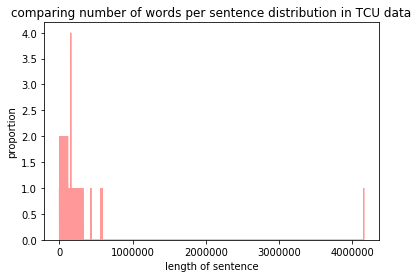

In [13]:
from matplotlib import pyplot as plt

tamanho_votos = [len(doc) for doc in data.VOTO]

plt.hist(tamanho_votos, bins=range(min(tamanho_votos), max(tamanho_votos) + 1, 1), histtype='step',
              alpha=0.4, color="red")
plt.xlabel("length of sentence")
plt.ylabel("proportion")
plt.title("comparing number of words per sentence distribution in TCU data")

### Calculando as similaridades entre os embeddings de diferentes técnicas

In [17]:
from annoy import AnnoyIndex

itd = AnnoyIndex(3072, 'angular')
itd.load('../results/itd_longformer.ann') # super fast, will just mmap the file

sentence = AnnoyIndex(512, 'angular')
sentence.load('../results/sentence_transformer.ann') # super fast, will just mmap the file

True

In [21]:
similarities = pd.read_csv('../results/tcu_similarities.csv', index_col=0)
similarities

,SOURCE_INDEX,SIMILAR_INDEX,COSINE_SIMILARITY,MODEL_NAME
0,217,99,NaN,bm25
1,217,36,NaN,bm25
2,217,26,NaN,bm25
3,217,27,NaN,bm25
4,217,28,NaN,bm25
...,...,...,...,...
1495,251,241,1.000000,itd_longformer
1496,251,251,1.000000,itd_longformer
1497,251,236,0.985196,itd_longformer
1498,251,238,0.985196,itd_longformer


In [27]:
models_dict = {}
for model_name, model_pairs in similarities.groupby('MODEL_NAME'):
    pairs = []
    for i, pair in model_pairs.iterrows():
        pairs.append((pair[0],pair[1]))
    models_dict[model_name]=set(pairs)

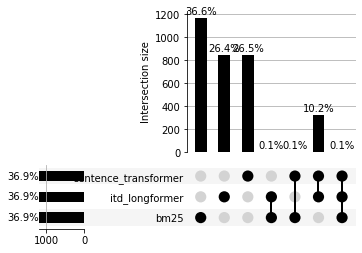

In [61]:
import itertools
from upsetplot import from_memberships, plot 
from matplotlib import pyplot
from itertools import chain, combinations

def powerset(iterable):
    "powerset([1,2,3]) --> () (1,) (2,) (3,) (1,2) (1,3) (2,3) (1,2,3)"
    s = list(iterable)
    return chain.from_iterable(combinations(s, r) for r in range(len(s)+1))

categories = []
values = []

#interseção
#TODO fazer a interseção com + de um
# for models_pairs in list(set(itertools.combinations(models_dict.keys(), 2))):
for models_pairs in powerset(models_dict.keys()):
    if len(models_pairs) > 1:
        categories.append(list(models_pairs))
    #     values.append(len(models_dict[models_pairs[0]].intersection(models_dict[models_pairs[1]])))
#         import pdb; pdb.set_trace()
#         *[models_dict[x] for x in models_pairs[1:]]
        values.append(len(models_dict[models_pairs[0]].intersection(*[models_dict[x] for x in models_pairs[1:]])))

#diferença simétrica
for model in models_dict.keys():
    difference = models_dict[model].symmetric_difference(set.union(*[models_dict[m] 
                                                         for m in models_dict.keys() 
                                                         if m != model]))
    categories.append([model])
    values.append(len(difference))
  
example = from_memberships( categories, data=values)
plot(example, show_percentages=True, )
# orientation='vertical',
# pyplot.legend(labelspacing=0.5)
pyplot.show()

## Upset lib test

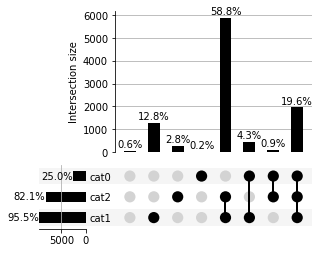

In [11]:
#Alexander Lex, Nils Gehlenborg, Hendrik Strobelt, Romain Vuillemot, Hanspeter Pfister, 
#UpSet: Visualization of Intersecting Sets, 
#IEEE Transactions on Visualization and Computer Graphics

from upsetplot import from_memberships, plot 
from matplotlib import pyplot
  
example = from_memberships(
   [[],
     ['cat2'],
     ['cat1'],
     ['cat1', 'cat2'],
     ['cat0'],
     ['cat0', 'cat2'],
     ['cat0', 'cat1'],
     ['cat0', 'cat1', 'cat2'],
    ],
      data=[56, 283, 1279, 5882, 24, 90, 429, 1957]
 )

plot(example, show_percentages=True)
# orientation='vertical',
pyplot.show()

# Tokens numbers boxplot

In [2]:
import pandas as pd

tcu_data = pd.read_csv('../datasets/jurisprudencias_tcu_final.csv')
tcu_data

,AREA,TEMA,SUBTEMA,ENUNCIADO,PROCESSO,ANO,TIPO_PROCESSO,RELATOR,VOTO
0,Responsabilidade,Convênio,Gestor sucessor,SÚMULA TCU 230: Compete ao prefeito sucessor a...,031.777/2010-4,2010,Tomada de Contas Especial,Augusto Nardes,\n TRIBUNAL DE CONTAS DA...
1,Responsabilidade,Convênio,Gestor sucessor,SÚMULA TCU 230: Compete ao prefeito sucessor a...,007.653/2009-2,2009,Tomada de Contas Especial,Vital do Rêgo,\n TRIBUNAL DE CONTAS DA...
2,Responsabilidade,Convênio,Gestor sucessor,SÚMULA TCU 230: Compete ao prefeito sucessor a...,029.768/2010-1,2010,Tomada de Contas Especial,José Mucio Monteiro,\n TRIBUNAL DE CONTAS DA...
3,Responsabilidade,Convênio,Gestor sucessor,SÚMULA TCU 230: Compete ao prefeito sucessor a...,009.607/2011-0,2011,Tomada de Contas Especial,Walton Alencar Rodrigues,\n TRIBUNAL DE CONTAS DA...
4,Responsabilidade,Convênio,Gestor sucessor,SÚMULA TCU 230: Compete ao prefeito sucessor a...,006.901/2013-1,2013,Tomada de Contas Especial,André de Carvalho,\n TRIBUNAL DE CONTAS DA...
...,...,...,...,...,...,...,...,...,...
366,Pessoal,Ressarcimento administrativo,Dispensa,SÚMULA TCU 249: É dispensada a reposição de im...,002.176/2000-3,10/12/2003,CONSULTA (CONS),WALTON ALENCAR RODRIGUES,Trata-se de Consulta formulada pelo Exmo. Sr. ...
367,Pessoal,Ressarcimento administrativo,Dispensa,SÚMULA TCU 249: É dispensada a reposição de im...,010.688/1999-4,08/12/2004,ACOMPANHAMENTO (ACOM),UBIRATAN AGUIAR,Cuidam os autos de Incidente de Uniformização ...
368,Pessoal,Ressarcimento administrativo,Dispensa,SÚMULA TCU 249: É dispensada a reposição de im...,675.083/1995-8,22/02/2005,TOMADA DE CONTAS (TC),MARCOS BEMQUERER,Examina-se nesta etapa processual o Recurso de...
369,Pessoal,Ressarcimento administrativo,Dispensa,SÚMULA TCU 249: É dispensada a reposição de im...,005.929/1999-7,23/08/2005,TOMADA DE CONTAS (TC),VALMIR CAMPELO,Trata-se dos Recursos de Reconsideração interp...


### With matplotlib

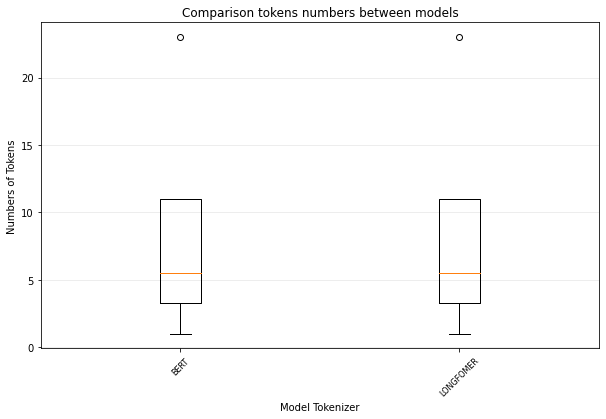

In [21]:

import matplotlib.pyplot as plt

fig, axs = plt.subplots(figsize=(10, 6))

data = [
   [1,23,4,7],
   [1,23,4,7]
]

models_name = ['BERT','LONGFOMER']
# basic plot
axs.boxplot(data)
axs.yaxis.grid(True, linestyle='-', which='major', color='lightgrey',
               alpha=0.5)

axs.set(
    axisbelow=True,  # Hide the grid behind plot objects
    title='Comparison tokens numbers between models',
    xlabel='Model Tokenizer',
    ylabel='Numbers of Tokens',
)

axs.set_xticklabels(models_name,
                    rotation=45, fontsize=8)

plt.savefig('teste.png',bbox_inches='tight')

### With seaborn

     total_bill   tip     sex smoker   day    time  size
0         16.99  1.01  Female     No   Sun  Dinner     2
1         10.34  1.66    Male     No   Sun  Dinner     3
2         21.01  3.50    Male     No   Sun  Dinner     3
3         23.68  3.31    Male     No   Sun  Dinner     2
4         24.59  3.61  Female     No   Sun  Dinner     4
..          ...   ...     ...    ...   ...     ...   ...
239       29.03  5.92    Male     No   Sat  Dinner     3
240       27.18  2.00  Female    Yes   Sat  Dinner     2
241       22.67  2.00    Male    Yes   Sat  Dinner     2
242       17.82  1.75    Male     No   Sat  Dinner     2
243       18.78  3.00  Female     No  Thur  Dinner     2

[244 rows x 7 columns]


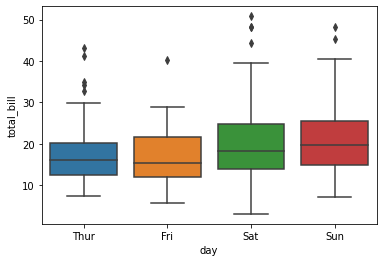

In [24]:
import seaborn as sns
# sns.set_theme(style="whitegrid")
tips = sns.load_dataset("tips")
print(tips)
ax = sns.boxplot(x="day", y="total_bill", data=tips)

In [11]:
import pandas as pd

stj1 = pd.read_csv('../results/stj/similarities.csv',index_col=0,)
print(len(stj1))
pruned = stj1[stj1.MODEL_NAME != 'sentence_transformer']
stj2 = pd.read_csv('../results/stj/similarities_2.csv',index_col=0,)

res = pd.concat([pruned, stj2], ignore_index=True)
res.to_csv('../results/stj/similarities_final.csv', index=False)

544180


In [12]:
tcu1 = pd.read_csv('../results/tcu/similarities.csv',index_col=0,)
print(len(tcu1))
pruned_2 = tcu1[tcu1.MODEL_NAME != 'sentence_transformer']
tcu2 = pd.read_csv('../results/tcu/similarities_2.csv',index_col=0,)

res = pd.concat([pruned_2, tcu2], ignore_index=True)
res.to_csv('../results/tcu/similarities_final.csv', index=False)

25970
